In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

from scipy.io import loadmat
from scipy.misc import imread

import os, pickle, tqdm

from util import *
%load_ext autoreload
%aimport util
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
videos = {}
squat_dir = Data + 'squats/'
for video in os.listdir(squat_dir):
    frames = []
    video_dir = squat_dir + video + '/'
    for frame in sorted(os.listdir(video_dir)):
        path = video_dir + str(frame)
        frames.append(imread(path))
    videos[video] = np.array(frames)

In [3]:
names = sorted(videos.keys())
np.random.seed(0)
np.random.shuffle(names)

In [4]:
N = len(names)
train_indices = int(0.8 * N)
val_indices = int(0.1 * N)
test_indices = int(0.1 * N)
dataset_names = {
    'train' : names[: train_indices],
    'val' : names[train_indices : train_indices + val_indices],
    'test' : names[train_indices + val_indices :]
}

In [9]:
means = []
for key in videos:
    means.append(np.mean(videos[key]))

In [18]:
labels_L_1 = {}
squat_label_dir = Data + 'squat_labels/'
i = 0
for video in os.listdir(squat_label_dir):
    if i < 100:
        frames = []
        video_dir = squat_label_dir + video + '/'
        for frame in sorted(os.listdir(video_dir)):
            file = video_dir + frame
            temp = imread(file).reshape((224, 224, 1))
            temp = temp - np.mean(temp)
    #         temp = temp/np.maximum(np.abs(np.minimum(temp)), np.abs(np.maximum(temp)))
            frames.append(temp)
        labels_L_1[video] = np.array(frames)
        i = i +1

In [9]:
output_dir = Data + 'squats_L_1/'
for set_name, video_names in dataset_names.items():
    set_dir = output_dir + set_name + '/'
    make_dir(set_dir)
    for name in video_names:
        video_dir = set_dir + name
        make_dir(video_dir)
        np.save(video_dir + '/video', videos[name])
        np.save(video_dir + '/poses_L_1', labels_L_1[name])

In [10]:
v = np.load(Data + 'squats_L_1/train/1832/video.npy')
p = np.load(Data + 'squats_L_1/train/1832/poses_L_1.npy')

In [12]:
from PIL import Image
np.array(Image.fromarray(v[0]).convert('L'))

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

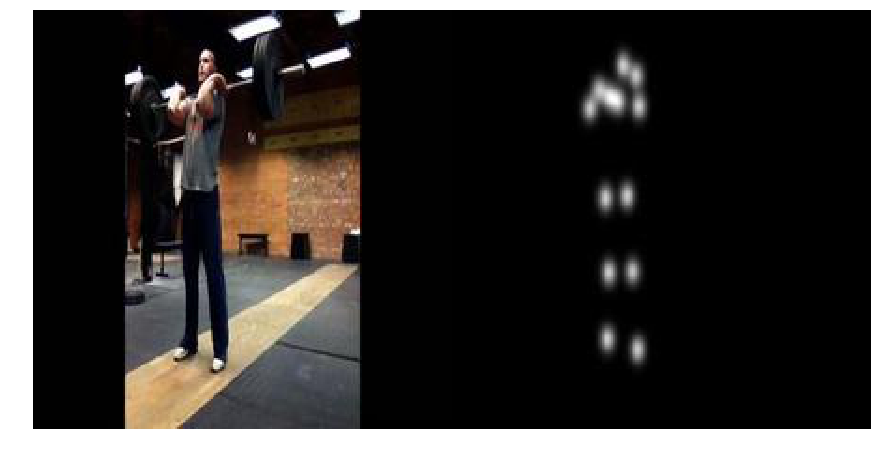

In [13]:
plt.imshow(v[0])
plt.imshow(p[0].reshape((224, 224)), alpha=0.5)
plt.show()

In [351]:
from skimage.draw import circle
from scipy.ndimage.filters import gaussian_filter
from scipy.misc import imresize

sigma = 5
labels_dir = Data + 'labels/'

labels_L_13 = {}

for name, path in list_dir(labels_dir, 'mat', return_name=True):
    annotations = loadmat(path)
    if annotations['action'] == 'squat':
        visible = annotations['visibility']
        h, w, n = annotations['dimensions'][0]
        poses = np.zeros((n, 224, 224, 13), dtype=np.uint8)

        xs = annotations['x'] * 224.0 / w
        ys = annotations['y'] * 224.0 / h
        
        for f_i in range(n):
            for p_i in range(13):
                if not visible[f_i][p_i]:
                    continue
                x, y = xs[f_i][p_i], ys[f_i][p_i]
                generate_heatmap(x, y, w, h, poses[f_i, :, :, p_i]) # from util
        labels_L_13[name] = poses

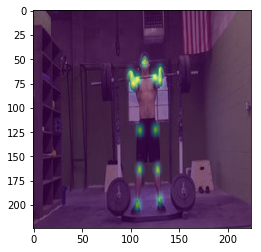

In [363]:
plt.imshow(videos['1668'][0])
plt.imshow(np.sum(labels_L_13['1668'][0], axis=2), alpha=0.6)
plt.show()

In [184]:
annotations = load_annotations()

## Create Videos in npy form

In [126]:
penn_dir = Data + 'Penn_Action/frames/'
videos_dir = Data + 'videos/'

In [ ]:
for vname in annotations:
    frames = [imread(path) for path in list_dir(penn_dir + vname + '/', 'jpg')]
    np.save(videos_dir + vname + '.npy', np.array(frames))

# Create videos in 224 x 224 gray and cropped gray form

In [181]:
videos_224_dir = Data + 'videos_224/'
videos_bbox_dir = Data + 'videos_bbox_224/'

In [ ]:
from scipy.misc import imresize

for vname, ann in tqdm.tqdm(annotations.iteritems()):
    video = np.load(videos_dir + vname + '.npy')
    video_224 = np.zeros((ann['nframes'], 224, 224, 3), dtype=np.uint8)
    video_224_bbox = np.zeros((ann['nframes'], 224, 224, 3), dtype=np.uint8)

    for i, (minx, miny, maxx, maxy) in enumerate(ann['bbox']):
        video_224[i] = imresize(video[i], (224, 224, 3))
        video_224_bbox[i] = imresize(video[i, miny : maxy, minx : maxx], (224, 224, 3))
    np.save(videos_224_dir + vname + '.npy', video_224)
    np.save(videos_bbox_dir + vname + '.npy', video_224_bbox)

In [13]:
from PIL import Image

v = np.load(Data + 'squats_L_1/train/1832/video.npy')

In [15]:
imageio.mimsave('/tmp/temp.gif', v)

In [24]:
from IPython.display import HTML
HTML('<img src="/tmp/temp.gif">')

## Visualize Pose

In [7]:
import sys, json
from easydict import EasyDict as edict
from util import *

sys.path.append(Data + 'Penn_Action')
import load_dataset

%load_ext autoreload
%aimport util
%aimport load_dataset
%autoreload 1

config_dir = os.path.join(Models, 'villegas_combined', 'gray_L_13_cropped')
config_path = os.path.join(config_dir, 'config.json')
with open(config_path, 'r+') as f:
    config = edict(json.load(f))
config.cropped = True
dataset = load_dataset.load_dataset(config)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
batch_size = 100
f1, p1, f2, p2 = dataset.get_train_batch(batch_size)
import matplotlib.pyplot as plt
%matplotlib inline
for i in range(batch_size):
    plt.imshow(f1[i][:, :, 0], cmap='gray')
    plt.imshow(np.sum(p1[i], axis=2), cmap='gray', alpha=0.6)
    plt.show()